<a href="https://colab.research.google.com/github/divyanshuraj6815/EVA6/blob/main/Experiment_3/experiment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
train_set = torchvision.datasets.MNIST(
    root='./data'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

![image.png](https://raw.githubusercontent.com/divyanshuraj6815/EVA6/main/Experiment_3/experiment_3_data.png)

In [7]:
# create a dataset class with 2 inputs and 2 outputs

class Addition(Dataset):
  def __init__(self, train_set):
    self.data = []
    for image, tag in iter (train_set):
      input = np.random.randint (10)
      output = tag + input
      self.data.append ((image, F.one_hot (torch.tensor (input), num_classes=10), tag, output))

  def __getitem__(self, index):
    r = self.data[index]
    image, input, label, output = r
    return image, input, label, output

  def __len__(self):
    return len(self.data)

dataset = Addition (train_set)
train_loader = DataLoader (dataset = dataset, batch_size = 128, shuffle = True)

In [8]:
len (next(iter(train_loader)))

4

Mish Activation function used
![image.png](https://miro.medium.com/max/3000/1*RuNM4YV8ZuitdLgkq_MPUw.png)

In [9]:
def mish (x):
  return (x * torch.tanh (F.softplus (x)))

![image.png](https://raw.githubusercontent.com/divyanshuraj6815/EVA6/main/Experiment_3/experiment_3_network.png)

In [24]:
class Multi_Input_Output_Network (nn.Module):
  def __init__ (self):
    super().__init__()

    self.conv1 = nn.Conv2d (in_channels = 1, out_channels = 16, kernel_size = 3) #28 => 26
    self.conv2 = nn.Conv2d (in_channels = 16, out_channels = 32, kernel_size = 3) #26 => 24
    self.max_pool1 = nn.MaxPool2d (2) #24 => 12

    self.conv3 = nn.Conv2d (in_channels = 32, out_channels = 64, kernel_size = 3) #12 =>10
    self.conv4 = nn.Conv2d (in_channels = 64, out_channels = 128, kernel_size = 3) #10 => 8
    self.max_pool2 = nn.MaxPool2d (2) #8 => 4

    self.conv5 = nn.Conv2d (in_channels = 128, out_channels = 256, kernel_size = 3) #4 => 2
    self.conv6 = nn.Conv2d (in_channels = 256, out_channels = 1024, kernel_size = 2) #2 > 1
    
    self.out1 = nn.Linear (in_features = 1024, out_features = 10)

    self.fc = nn.Linear (in_features = 10, out_features = 20)
    self.out2 = nn.Linear (in_features = 40, out_features = 19)

  def forward (self, image, number):

    image = self.max_pool1 (self.conv2 (F.relu (self.conv1 (image))))
    image = self.max_pool2 (self.conv4 (F.relu (self.conv3 (image))))
    image = F.relu (self.conv5 (image))
    image = image.reshape (-1, 1024)
    image = self.out1 (image)

    number = torch.cat ((mish (image.unsqueeze (dim=1)), number.unsqueeze (dim=1)), dim=1)
    number = self.fc (number)
    number = number.reshape (-1, 40)
    number = self.out2 (number)

    return F.log_softmax(image), F.log_softmax(number)

In [25]:
network = Multi_Input_Output_Network ()
network.to (device)

Multi_Input_Output_Network(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(256, 1024, kernel_size=(2, 2), stride=(1, 1))
  (out1): Linear(in_features=1024, out_features=10, bias=True)
  (fc): Linear(in_features=10, out_features=20, bias=True)
  (out2): Linear(in_features=40, out_features=19, bias=True)
)

In [26]:
batch = next(iter(train_loader))
len(batch)

4

In [27]:
images, numbers, labels, outputs = batch

print (images.shape, numbers.shape)
pred_1, pred_2 = network (images.to (device), numbers.to (device))

print (pred_1.shape)
print (pred_2.shape)

torch.Size([128, 1, 28, 28]) torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 19])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [28]:
pred_1[0].argmax(dim=0)
pred_2[0].argmax(dim=0)

tensor(15, device='cuda:0')

In [29]:
import torch.optim as optim
optimizer = optim.SGD (network.parameters(), lr=0.01, momentum=0.9)

In [30]:
params = network.state_dict ()
params.keys ()

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'conv4.weight', 'conv4.bias', 'conv5.weight', 'conv5.bias', 'conv6.weight', 'conv6.bias', 'out1.weight', 'out1.bias', 'fc.weight', 'fc.bias', 'out2.weight', 'out2.bias'])

In [31]:
def get_num_correct(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

In [32]:
graph_loss_1 = []
graph_loss_2 = []
graph_correct_1 = []
graph_correct_2 = []

In [45]:
import matplotlib.pyplot as plt

def plot_graph ():
  plt.rcParams["figure.figsize"] = (15,10)

  plt.subplot (2, 2, 1)
  plt.plot (graph_loss_1)
  plt.title ('MNIST Loss')

  plt.subplot (2, 2, 2)
  plt.plot (graph_loss_2)
  plt.title ('Add Loss')

  plt.subplot (2, 2, 3)
  plt.plot (graph_correct_1)
  plt.title ('MNIST Accuracy')

  plt.subplot (2, 2, 4)
  plt.plot (graph_correct_2)
  plt.title ('Add Accuracy')

  plt.show ()

Keep the weights w.r.t addition constant and train the mnist first

In [33]:
# Train model
num_epochs = 20

#freeze the addition network
for name, param in network.named_parameters():
  if param.requires_grad and ('fc' in name or 'out2' in name):
    print (name)
    param.requires_grad = False

for epoch in range(num_epochs):    
  total_loss_1 = total_loss_2 = 0
  total_correct_1 = total_correct_2 = 0
  for batch in train_loader:
    images, numbers, labels, outputs = batch
    pred_1, pred_2 = network (images.to (device), numbers.to(device))
    
    loss_1, loss_2 = F.cross_entropy (pred_1, labels.to (device)), F.cross_entropy (pred_2, outputs.to (device))
    loss = loss_1

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss_1 += loss.item ()
    total_loss_2 += loss_2.item ()
    total_correct_1 += get_num_correct (pred_1, labels.to (device))
    total_correct_2 += get_num_correct (pred_2, outputs.to (device))
  
  graph_loss_1.append (total_loss_1)
  graph_loss_2.append (total_loss_2)
  graph_correct_1.append (total_correct_1 * 100 / 60000)
  graph_correct_2.append (total_correct_2 * 100 / 60000)

  print(
    "epoch", epoch, 
    "total_correct_1:", total_correct_1 * 100 / 60000,
    "total_correct_2:", total_correct_2 * 100 / 60000, 
    "loss_1:", total_loss_1,
    "loss_2:", total_loss_2
  )
plot_graph ()

fc.weight
fc.bias
out2.weight
out2.bias


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


epoch 0 total_correct_1: 80.13333333333334 total_correct_2: 3.848333333333333 loss_1: 290.52135745063424 loss_2: 1475.788362979889
epoch 1 total_correct_1: 97.73 total_correct_2: 3.388333333333333 loss_1: 34.11355118220672 loss_2: 1551.2785482406616
epoch 2 total_correct_1: 98.46 total_correct_2: 3.3383333333333334 loss_1: 23.012670191936195 loss_2: 1586.949386358261
epoch 3 total_correct_1: 98.89333333333333 total_correct_2: 3.3216666666666668 loss_1: 16.964175008237362 loss_2: 1621.8921866416931
epoch 4 total_correct_1: 99.10833333333333 total_correct_2: 3.2666666666666666 loss_1: 13.164600205578608 loss_2: 1661.5110635757446
epoch 5 total_correct_1: 99.305 total_correct_2: 3.4283333333333332 loss_1: 10.25030180052272 loss_2: 1704.206036567688
epoch 6 total_correct_1: 99.47 total_correct_2: 3.3233333333333333 loss_1: 8.679076559725218 loss_2: 1736.5945692062378
epoch 7 total_correct_1: 99.48 total_correct_2: 3.24 loss_1: 7.480223501275759 loss_2: 1760.9316790103912
epoch 8 total_corr

Keep the weight w.r.t mnist constant and train the weights for addition now 

conv1.weight
conv1.bias
conv2.weight
conv2.bias
conv3.weight
conv3.bias
conv4.weight
conv4.bias
conv5.weight
conv5.bias
conv6.weight
conv6.bias
out1.weight
out1.bias


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


epoch 0 total_correct_1: 99.84166666666667 total_correct_2: 10.97 loss_1: 2.648342359716935 loss_2: 1152.2815961837769
epoch 1 total_correct_1: 99.84166666666667 total_correct_2: 16.455 loss_1: 2.671453300064968 loss_2: 1069.2628617286682
epoch 2 total_correct_1: 99.84166666666667 total_correct_2: 20.605 loss_1: 2.6728112524078824 loss_2: 1001.8369781970978
epoch 3 total_correct_1: 99.84166666666667 total_correct_2: 23.963333333333335 loss_1: 2.670277204832928 loss_2: 949.4728757143021
epoch 4 total_correct_1: 99.84166666666667 total_correct_2: 25.015 loss_1: 2.6706886142314943 loss_2: 927.5671302080154
epoch 5 total_correct_1: 99.84166666666667 total_correct_2: 27.041666666666668 loss_1: 2.670358409376604 loss_2: 898.6131089925766
epoch 6 total_correct_1: 99.84166666666667 total_correct_2: 28.523333333333333 loss_1: 2.6701981008723124 loss_2: 873.0615130662918
epoch 7 total_correct_1: 99.84166666666667 total_correct_2: 29.501666666666665 loss_1: 2.670244495539009 loss_2: 855.176094412

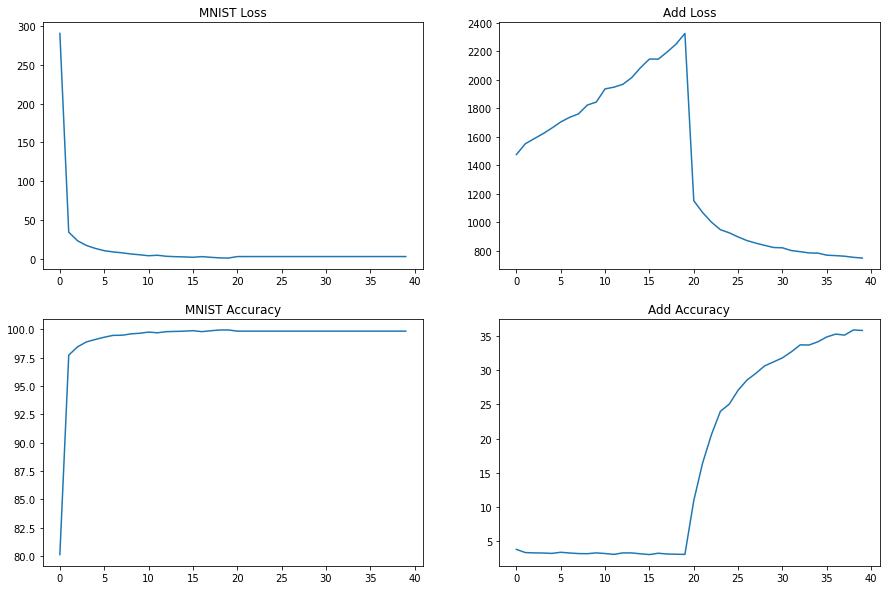

In [46]:
# Train model
num_epochs = 20

#freeze the addition network
for name, param in network.named_parameters():
  if 'fc' in name or 'out2' in name:
    param.requires_grad = True
  else:
    print (name)
    param.requires_grad = False

for epoch in range(num_epochs):    
  total_loss_1 = total_loss_2 = 0
  total_correct_1 = total_correct_2 = 0

  for batch in train_loader:
    images, numbers, labels, outputs = batch
    pred_1, pred_2 = network (images.to (device), numbers.to(device))
    
    loss_1, loss_2 = F.cross_entropy (pred_1, labels.to (device)), F.cross_entropy (pred_2, outputs.to (device))
    loss = loss_2

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss_1 += loss_1.item ()
    total_loss_2 += loss_2.item ()
    total_correct_1 += get_num_correct (pred_1, labels.to (device))
    total_correct_2 += get_num_correct (pred_2, outputs.to (device))
  
  graph_loss_1.append (total_loss_1)
  graph_loss_2.append (total_loss_2)
  graph_correct_1.append (total_correct_1 * 100 / 60000)
  graph_correct_2.append (total_correct_2 * 100 / 60000)

  print(
    "epoch", epoch, 
    "total_correct_1:", total_correct_1 * 100 / 60000,
    "total_correct_2:", total_correct_2 * 100 / 60000, 
    "loss_1:", total_loss_1,
    "loss_2:", total_loss_2
  )
plot_graph ()

Now train all the weights together

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


epoch 0 total_correct_1: 99.71166666666667 total_correct_2: 54.77333333333333 loss_1: 560.1977353692055 loss_2: 556.2564972043037
epoch 1 total_correct_1: 99.70166666666667 total_correct_2: 67.285 loss_1: 452.8748913407326 loss_2: 448.1476695537567
epoch 2 total_correct_1: 99.69666666666667 total_correct_2: 73.55 loss_1: 398.10771691799164 loss_2: 392.9202400445938
epoch 3 total_correct_1: 99.695 total_correct_2: 78.81 loss_1: 357.95089691877365 loss_2: 352.48321825265884
epoch 4 total_correct_1: 99.67833333333333 total_correct_2: 81.87166666666667 loss_1: 329.42975383996964 loss_2: 323.6532021164894
epoch 5 total_correct_1: 99.81833333333333 total_correct_2: 84.33333333333333 loss_1: 298.5590726137161 loss_2: 293.84476557374
epoch 6 total_correct_1: 99.76166666666667 total_correct_2: 86.84333333333333 loss_1: 281.0484416484833 loss_2: 275.854286134243
epoch 7 total_correct_1: 99.80166666666666 total_correct_2: 88.12 loss_1: 260.94896999001503 loss_2: 256.04517701268196
epoch 8 total_c

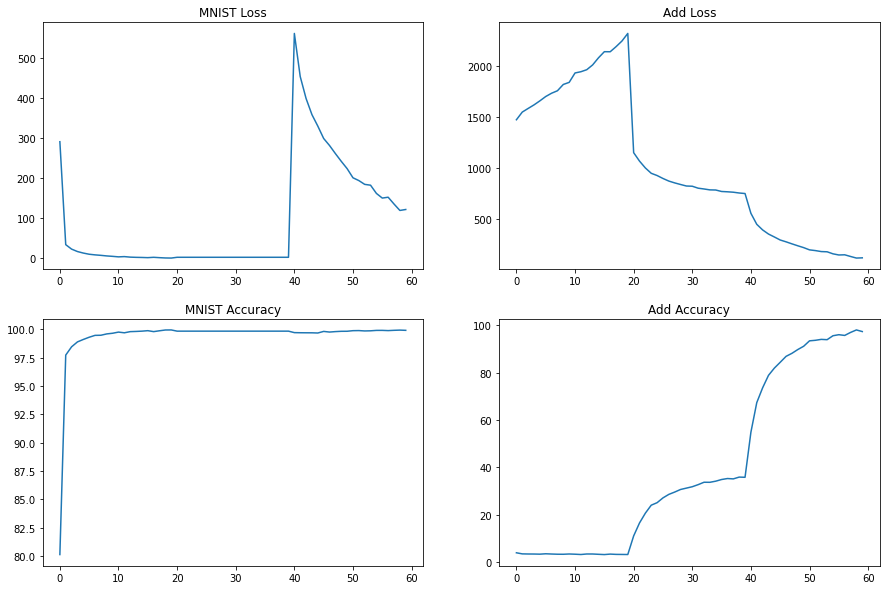

In [47]:
# Train model
num_epochs = 20

#freeze the addition network
for name, param in network.named_parameters():
  param.requires_grad = True

for epoch in range(num_epochs):    
  total_loss_1 = total_loss_2 = 0
  total_correct_1 = total_correct_2 = 0
    
  for batch in train_loader:
    images, numbers, labels, outputs = batch
    pred_1, pred_2 = network (images.to (device), numbers.to(device))
    
    loss_1, loss_2 = F.cross_entropy (pred_1, labels.to (device)), F.cross_entropy (pred_2, outputs.to (device))
    loss = torch.add (loss_1, loss_2)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss_1 += loss.item ()
    total_loss_2 += loss_2.item ()
    total_correct_1 += get_num_correct (pred_1, labels.to (device))
    total_correct_2 += get_num_correct (pred_2, outputs.to (device))
  
  graph_loss_1.append (total_loss_1)
  graph_loss_2.append (total_loss_2)
  graph_correct_1.append (total_correct_1 * 100 / 60000)
  graph_correct_2.append (total_correct_2 * 100 / 60000)

  print(
    "epoch", epoch, 
    "total_correct_1:", total_correct_1 * 100 / 60000,
    "total_correct_2:", total_correct_2 * 100 / 60000, 
    "loss_1:", total_loss_1,
    "loss_2:", total_loss_2
  )
plot_graph ()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


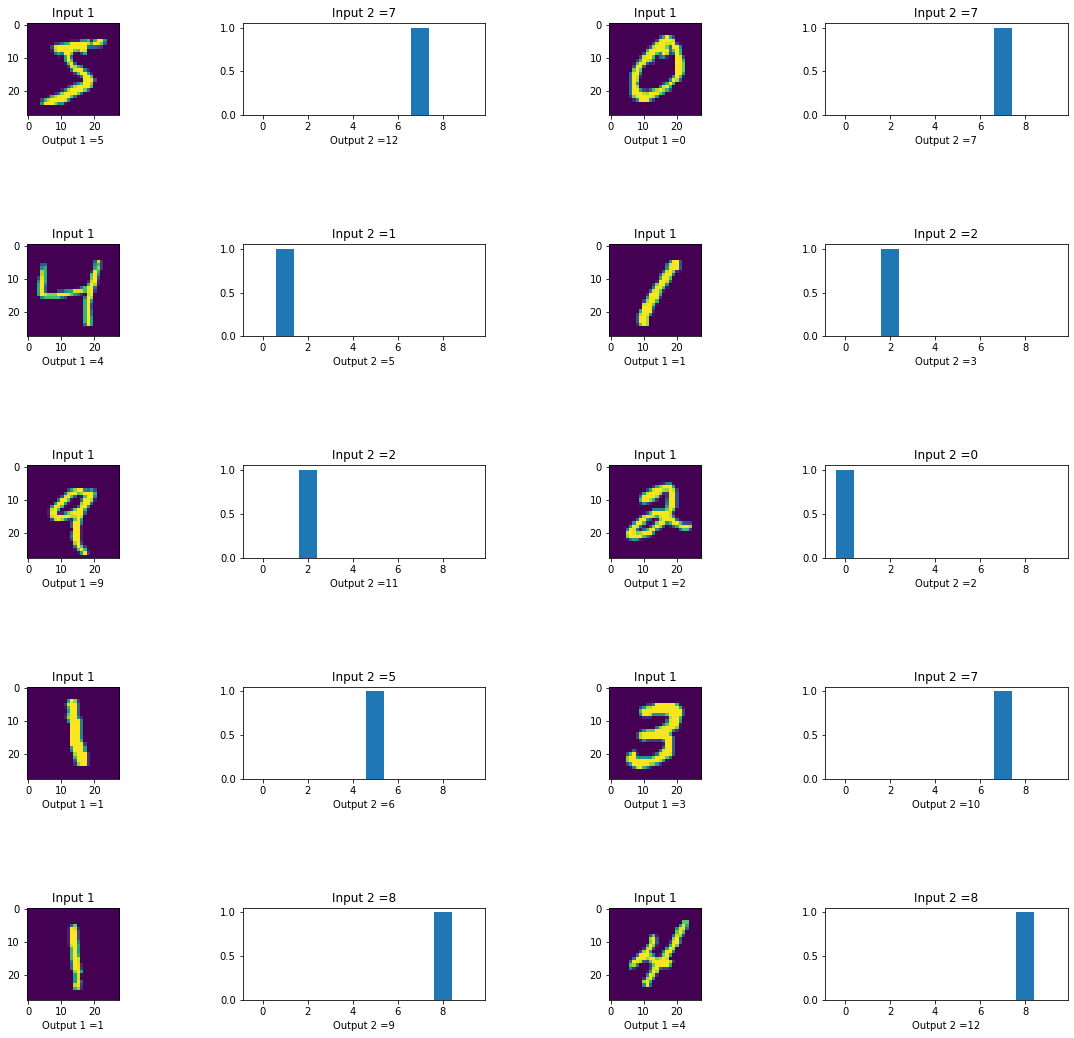

In [96]:

indexes = range (10)
i = 0
plt.rcParams["figure.figsize"] = (20,20)

for index in indexes:
  image, number, label, output = dataset[ index ]

  images, numbers = image.unsqueeze (dim = 0).to (device), number.unsqueeze (dim = 0).to (device)
  pred_1, pred_2 = network (images, numbers)
  #print (label, pred_1[0].argmax ())
  #print (output, pred_2[0].argmax ())

  plt.subplot (10, 4, i + 1)
  plt.imshow (image.squeeze (dim=0))
  plt.title ('Input 1')
  plt.xlabel ('Output 1 =' + str (pred_1[0].argmax ().item ()))

  plt.subplot (10, 4, i + 2)
  plt.bar (range(10), number.squeeze (dim=0))
  plt.title ('Input 2 =' + str (number.argmax (dim=0).item ()))
  plt.xlabel ('Output 2 =' + str (pred_2[0].argmax ().item ()))

  i += 2
  if i % 4 == 0:
    i += 4
plt.show ()